<h1 style="text-align: center" >Stock Prediction Using Logistic Regression</h1>

## Import Libraries

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

## Functions

### Preprocessing

In [2]:
def preprocess_data(df, days_ahead=30, window_size=30):
    df["Label"] = df["Close"].shift(-days_ahead)
    df["30_day_moving_average"] = df["Close"].rolling(window=window_size).mean()

    df.dropna(inplace=True)
    return df

### Load Data

In [3]:
def load_data(stock):
    stock = stock.upper()
    df = pd.read_csv(f"nasdaq/{stock}.csv", parse_dates=["Date"], dayfirst=True)
    df = preprocess_data(df)
    df.index = df.pop("Date")
    return df

### LSTM Functions

In [4]:
def df_to_windowed_df(df, n=3):
    last_date = df.index.max()
    target_date = df.index[n]

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = df.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f"Error: Window of size {n} is too large for date {target_date}")
            return

        values = df_subset["Close"].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date : target_date + datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split("T")[0]
        year_month_day = next_date_str.split("-")
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df["Target Date"] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f"Target-{n-i}"] = X[:, i]

    ret_df["Target"] = Y

    return ret_df

In [5]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
  
    dates = df_as_np[:, 0]
  
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  
    Y = df_as_np[:, -1]
  
    return dates, X.astype(np.float32), Y.astype(np.float32)

## Train and Test Models

### Amazon Dataframe

In [6]:
df = load_data("AMZN")

In [7]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1997-06-26,0.075260,0.076042,63792000,0.076042,0.075521,0.075521,0.114583,0.077891
1997-06-27,0.073958,0.075781,23760000,0.075781,0.074479,0.074479,0.116406,0.077109
1997-06-30,0.073958,0.075521,54936000,0.079948,0.077083,0.077083,0.109896,0.076797
1997-07-01,0.075521,0.077083,25848000,0.077083,0.075781,0.075781,0.109896,0.076476
1997-07-02,0.075521,0.075781,77640000,0.079688,0.079427,0.079427,0.107813,0.076398
...,...,...,...,...,...,...,...,...
2022-10-24,116.570000,119.980003,49531500,120.389999,119.820000,119.820000,88.250000,117.587667
2022-10-25,118.949997,119.650002,50934600,121.320000,120.599998,120.599998,88.459999,117.380333
2022-10-26,114.760002,116.000000,68802300,119.349998,115.660004,115.660004,90.349998,116.950667


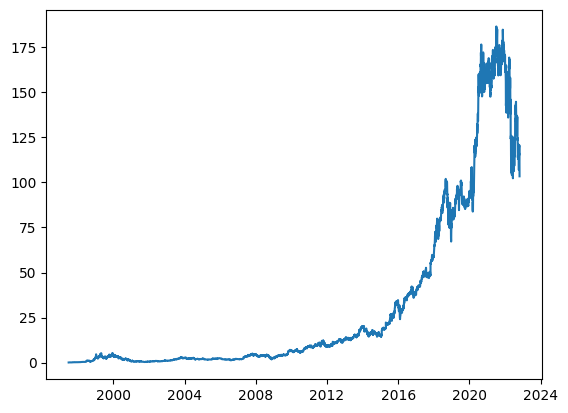

In [8]:
plt.plot(df.index, df['Close'])

In [9]:
X = df.drop(columns="Label")
y = df["Label"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

#### Training

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Results

In [13]:
train_pred = lr.predict(X_train).flatten()
test_pred = lr.predict(X_test).flatten()

In [14]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 6.21 RMSE
Test Score: 5.99 RMSE


### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

#### Training

In [16]:
rf = RandomForestRegressor(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

#### Results

In [17]:
train_pred = rf.predict(X_train).flatten()
test_pred = rf.predict(X_test).flatten()

In [18]:
# sort the data by date for plotting
train_dates = X_train.index.to_series().sort_values()
test_dates = X_test.index.to_series().sort_values()

In [19]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 1.46 RMSE
Test Score: 4.17 RMSE


### LSTM

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2023-04-29 23:37:43.324217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 23:37:43.403620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-29 23:37:43.403631: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-29 23:37:43.809997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

#### Training

In [21]:
windowed_df = df_to_windowed_df(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1997-07-01,0.075521,0.074479,0.077083,0.075781
1,1997-07-02,0.074479,0.077083,0.075781,0.079427
2,1997-07-03,0.077083,0.075781,0.079427,0.095573
3,1997-07-07,0.075781,0.079427,0.095573,0.100000
4,1997-07-08,0.079427,0.095573,0.100000,0.115104
...,...,...,...,...,...
6371,2022-10-24,115.070000,115.250000,119.320000,119.820000
6372,2022-10-25,115.250000,119.320000,119.820000,120.599998
6373,2022-10-26,119.320000,119.820000,120.599998,115.660004
6374,2022-10-27,119.820000,120.599998,115.660004,110.959999


In [22]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((6376,), (6376, 3, 1), (6376,))

In [23]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

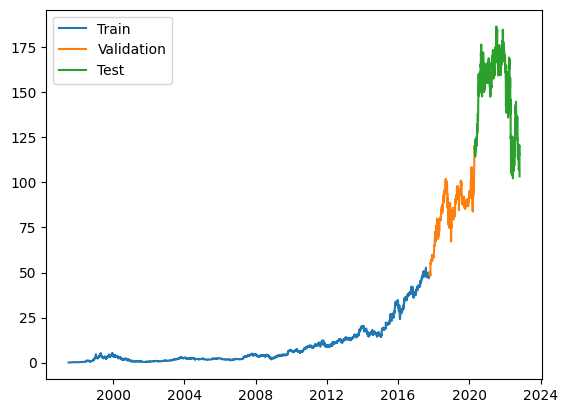

In [24]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [25]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2023-04-29 23:37:45.950943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 23:37:45.951075: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-29 23:37:45.951114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-29 23:37:45.951150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-29 23:37:45.951186: W tensorflow/c

Epoch 1/100
160/160 [==============================] - 2s 3ms/step - loss: 62.4202 - mean_absolute_error: 3.1714 - val_loss: 1378.9886 - val_mean_absolute_error: 34.7253
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 0.1281 - mean_absolute_error: 0.1923 - val_loss: 1188.8518 - val_mean_absolute_error: 31.9283
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0862 - mean_absolute_error: 0.1604 - val_loss: 1133.5568 - val_mean_absolute_error: 31.0867
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0976 - mean_absolute_error: 0.1708 - val_loss: 1114.8043 - val_mean_absolute_error: 30.7729
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 0.0948 - mean_absolute_error: 0.1725 - val_loss: 1102.5833 - val_mean_absolute_error: 30.6044
Epoch 6/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0938 - mean_absolute_error: 0.1674 - val_loss: 1097.8635 - val_mean_absolute_

#### Results

20/20 [==============================] - 0s 985us/step


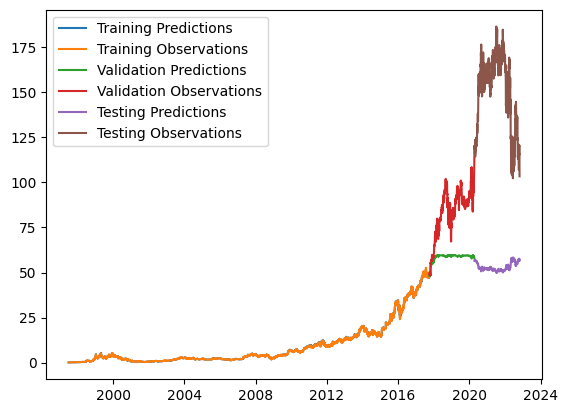

In [26]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

# training data
plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)

# validation data
plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)

# testing data
plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [27]:
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = np.sqrt(mean_squared_error(y_val, val_pred))
print('Cross Validation Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.25 RMSE
Cross Validation Score: 0.25 RMSE
Test Score: 100.65 RMSE


### Apple Dataframe

In [28]:
df = load_data("AAPL")

In [29]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1981-01-26,0.143973,0.144531,24640000,0.144531,0.143973,0.112032,0.100446,0.139788
1981-01-27,0.142857,0.143973,23699200,0.143973,0.142857,0.111164,0.096540,0.140272
1981-01-28,0.138393,0.138951,28156800,0.138951,0.138393,0.107690,0.100446,0.140830
1981-01-29,0.133371,0.133929,43904000,0.133929,0.133371,0.103782,0.099330,0.141518
1981-01-30,0.126116,0.127232,46188800,0.127232,0.126116,0.098137,0.103237,0.141871
...,...,...,...,...,...,...,...,...
2022-10-24,146.000000,147.190002,75981900,150.229996,149.449997,149.202484,142.910004,146.774998
2022-10-25,149.360001,150.089996,74732300,152.490005,152.339996,152.087708,140.940002,146.724998
2022-10-26,148.039993,150.960007,88194300,151.990005,149.350006,149.102661,142.649994,146.526332


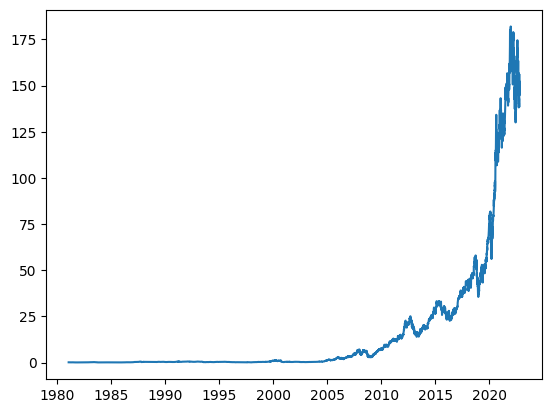

In [30]:
plt.plot(df.index, df['Close'])

In [31]:
X = df.drop(columns="Label")
y = df["Label"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Intel Dataframe

In [33]:
df = load_data("INTC")

In [34]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1980-04-28,0.312500,0.315104,6931200,0.317708,0.312500,0.190400,0.350260,0.311111
1980-04-29,0.315104,0.315104,6297600,0.320313,0.315104,0.191986,0.354167,0.310764
1980-04-30,0.319010,0.319010,7065600,0.324219,0.319010,0.194366,0.348958,0.310634
1980-05-01,0.320313,0.320313,7008000,0.325521,0.320313,0.195160,0.348958,0.310287
1980-05-02,0.325521,0.325521,5510400,0.330729,0.325521,0.198333,0.348958,0.310156
...,...,...,...,...,...,...,...,...
2022-10-24,26.520000,26.750000,43831600,27.480000,27.180000,27.180000,28.600000,27.126000
2022-10-25,27.000000,27.180000,32205300,27.559999,27.410000,27.410000,28.330000,27.063333
2022-10-26,26.990000,27.190001,37111100,27.799999,27.209999,27.209999,28.440001,26.997667


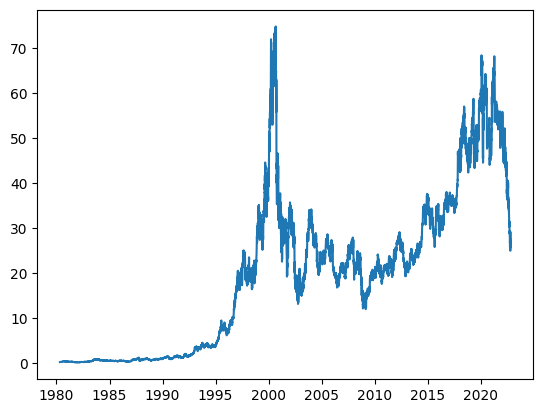

In [35]:
plt.plot(df.index, df['Close'])

In [36]:
X = df.drop(columns="Label")
y = df["Label"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Microsoft Dataframe

In [38]:
df = load_data("MSFT")

In [39]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1986-04-24,0.099826,0.100260,62352000,0.111979,0.110243,0.069860,0.118924,0.098249
1986-04-25,0.111111,0.111111,85795200,0.121962,0.117188,0.074261,0.113715,0.098915
1986-04-28,0.116319,0.117188,28886400,0.118924,0.118056,0.074811,0.113715,0.099494
1986-04-29,0.113715,0.118056,30326400,0.118056,0.114583,0.072610,0.113715,0.099899
1986-04-30,0.109375,0.114583,30902400,0.115451,0.111979,0.070960,0.109375,0.100304
...,...,...,...,...,...,...,...,...
2022-10-24,241.300003,243.759995,24911200,247.839996,247.250000,247.250000,245.119995,239.519000
2022-10-25,245.830002,247.259995,34775500,251.039993,250.660004,250.660004,244.369995,239.474667
2022-10-26,230.059998,231.169998,82543200,238.300003,231.320007,231.320007,247.399994,238.778000


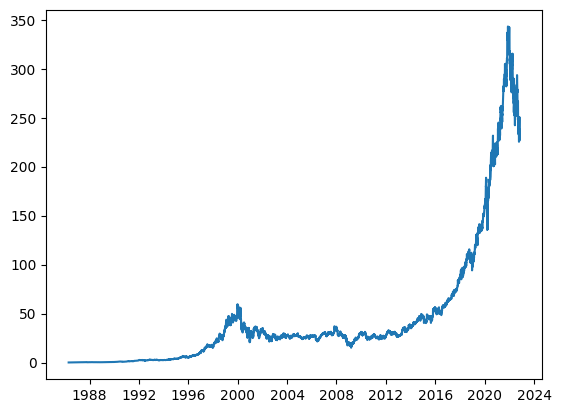

In [40]:
plt.plot(df.index, df['Close'])

In [41]:
X = df.drop(columns="Label")
y = df["Label"]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Nvidia Dataframe

In [43]:
df = load_data("NVDA")

In [44]:
df

,Low,Open,Volume,High,Close,Adjusted Close,Label,30_day_moving_average
Date,,,,,,,,
1999-03-05,0.419271,0.419271,7876800,0.440104,0.438802,0.403209,0.395833,0.423785
1999-03-08,0.419271,0.427083,7588800,0.458333,0.445313,0.409191,0.388021,0.424957
1999-03-09,0.444010,0.444010,14318400,0.466146,0.459635,0.422352,0.394531,0.425174
1999-03-10,0.445313,0.466146,23534400,0.466146,0.451823,0.415173,0.377604,0.426302
1999-03-11,0.432292,0.444010,5428800,0.451823,0.432292,0.397227,0.359375,0.426823
...,...,...,...,...,...,...,...,...
2022-10-24,120.639999,125.080002,51745700,127.099998,125.989998,125.989998,159.869995,124.739999
2022-10-25,126.639999,126.940002,50548200,133.000000,132.610001,132.610001,161.199997,124.783333
2022-10-26,127.080002,128.690002,53295300,133.880005,128.960007,128.960007,171.690002,124.706000


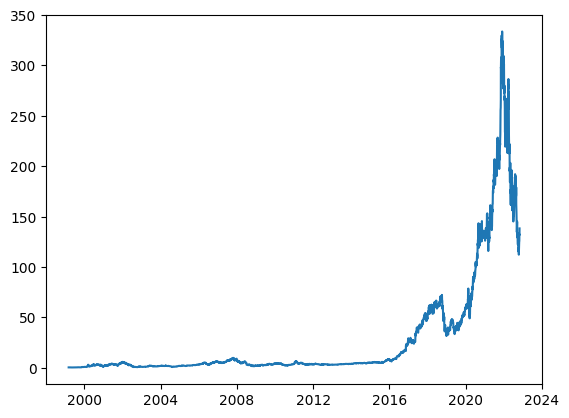

In [45]:
plt.plot(df.index, df['Close'])

In [46]:
X = df.drop(columns="Label")
y = df["Label"]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)